**Almgren Chriss algorithm**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [9]:
figure2_params = {'X':       10**6,         # shares
                  'T':       5,             # days
                  'N':       5,
                  'sigma':   0.95,          # dollars per share per day sqrt
                  'epsilon': 0.0625,        # dollars per share
                  'gamma':   2.5*10**(-7),  # dollars per share squared
                  'eta':     2.5*10**(-6),  # dollars per day
                  'lbda':    2*10**(-6)}

In [10]:
def _eta_tilde(eta, gamma, tau):
    return eta*(1 - (gamma*tau)/(2*eta))


def _kappa_tilde_squared(lbda, sigma, eta_tilde):
    return lbda*(sigma**2)/eta_tilde


def _kappa(kappa_tilde_squared, tau):
    return np.arccosh(kappa_tilde_squared*(tau**2)/2 + 1)/tau


def derived_params(eta, gamma, tau, lbda, sigma):
    eta_tilde = _eta_tilde(eta, gamma, tau)
    kappa_tilde_squared = _kappa_tilde_squared(lbda, sigma, eta_tilde)
    kappa = _kappa(kappa_tilde_squared, tau)

    return eta_tilde, kappa


def almgren_chriss(big_x, big_n, big_t, sigma, lbda, eta, gamma):
    tau = big_t/big_n
    eta_tilde, kappa = derived_params(eta, gamma, tau, lbda, sigma)

    t_j = np.linspace(0, big_t, big_n + 1)
    inventory_values = big_x*np.sinh(kappa*(big_t - t_j))/np.sinh(kappa*big_t)

    return pd.Series(inventory_values, t_j)

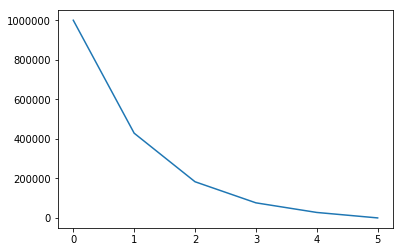

In [11]:
big_x = figure2_params['X']
big_n = figure2_params['N']
big_t = figure2_params['T']
sigma = figure2_params['sigma']
eta = figure2_params['eta']
gamma = figure2_params['gamma']
lbda = figure2_params['lbda']

trajectory = almgren_chriss(big_x, big_n, big_t, sigma, lbda, eta, gamma)
trajectory.plot('line')


**Optimal Execution Horizon algorithm** 

Implementation d'un autre algorithme que j'ai trouvé online (peut être intéressant, peut être à jeter), je le laisse la pour le moment

In [12]:
# PARAMETERS
sigma=1000
volSigma=10000
S_S=10000
zLambda=-1.644853627 #CDF(0.05) from the Std Normal dist
vB=0.4
phi=0.999
m=1000

In [13]:
def signum(int):
    if(int < 0):return -1
    elif(int > 0):return 1
    else:return 0

In [14]:
def getOI(v,m,phi,vB,sigma,volSigma):
    return phi*(float(m-(2*vB-1)*abs(m))/v+2*vB-1)+ (1-phi)*(2*vB-1)

In [15]:
def getBounds(m,phi,vB,sigma,volSigma,S_S,zLambda,k=0):
    vB_l=float(signum(m)+1)/2-zLambda*sigma*abs(m)**0.5/ float(4*phi*(S_S+abs(m)*k)*volSigma**0.5)
    vB_u=float(signum(m)+1)/2+zLambda*sigma*abs(m)**0.5/ float(4*phi*(S_S+abs(m)*k)*volSigma**0.5)
    vB_z=(signum(m)*phi/(float(phi)-1)+1)/2.
    return vB_l,vB_u,vB_z

In [16]:
def minFoot(m,phi,vB,sigma,volSigma,S_S,zLambda,k=0):
    
    vB_l,vB_u,vB_z=getBounds(m,phi,vB,sigma,volSigma,S_S, zLambda,k)

 
    if (2*vB-1)*abs(m)<m:
    
        v1=(2*phi*((2*vB-1)*abs(m)-m)*S_S*volSigma**0.5/float(zLambda*sigma))**(2./3)
        oi=getOI(v1,m,phi,vB,sigma,volSigma)
        if oi>0:
            if vB<=vB_u: return v1
            if vB>vB_u: return abs(m)
    
    elif (2*vB-1)*abs(m)>m:
        
        v2=(2*phi*(m-(2*vB-1)*abs(m))*S_S*volSigma**0.5/float(zLambda*sigma))**(2./3)
        oi=getOI(v2,m,phi,vB,sigma,volSigma)
        if oi<0:
            if vB>=vB_l: return v2
            if vB<vB_l: return abs(m)
        
        
    elif (2*vB-1)*abs(m)==m: return abs(m)
    
    if vB>=vB_z: return phi*(abs(m)-m/float(2*vB-1))
    if vB<vB_z: return abs(m)
   
         
 

In [17]:
print (minFoot(m,phi,vB,sigma,volSigma,S_S,zLambda))

5994.0


**Example for getting minute data from the google finance API**

In [22]:
import csv
import datetime
import re

import pandas as pd
import requests

def get_google_finance_intraday(ticker, period=60, days=1):
    """
    Retrieve intraday stock data from Google Finance.
    Parameters
    ----------
    ticker : str
        Company ticker symbol.
    period : int
        Interval between stock values in seconds.
    days : int
        Number of days of data to retrieve.
    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the opening price, high price, low price,
        closing price, and volume. The index contains the times associated with
        the retrieved price values.
    """

    uri = 'http://www.google.com/finance/getprices' \
          '?i={period}&p={days}d&f=d,o,h,l,c,v&df=cpct&q={ticker}'.format(ticker=ticker,
                                                                          period=period,
                                                                          days=days)
    page = requests.get(uri)
    reader = csv.reader(page.content.splitlines())
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    rows = []
    times = []
    for row in reader:
        if re.match('^[a\d]', row[0]):
            if row[0].startswith('a'):
                start = datetime.datetime.fromtimestamp(int(row[0][1:]))
                times.append(start)
            else:
                times.append(start+datetime.timedelta(seconds=period*int(row[0])))
            rows.append(map(float, row[1:]))
    if len(rows):
        return pd.DataFrame(rows, index=pd.DatetimeIndex(times, name='Date'),
                            columns=columns)
    else:
        return pd.DataFrame(rows, index=pd.DatetimeIndex(times, name='Date'))

In [29]:
f=get_google_finance_intraday('AAPL',5, 3)
f["VWAP"]=(f.Volume*(f.High+f.Low)/2).cumsum() / f.Volume.cumsum()
f.head()

,Open,High,Low,Close,Volume,VWAP
Date,,,,,,
2018-04-04 15:30:00,164.900,164.9350,164.77,164.88,449764.0,164.852500
2018-04-04 15:31:00,165.255,165.3672,164.82,164.86,417756.0,164.968602
2018-04-04 15:32:00,165.740,165.8000,165.23,165.25,188968.0,165.066333
2018-04-04 15:33:00,166.070,166.2400,165.68,165.74,184444.0,165.199162
2018-04-04 15:34:00,166.050,166.2890,165.96,166.07,152434.0,165.300394
